# Содержание

<a id='section_id'></a>[Определение перспективного тарифа для телеком-компании](#section_id)

<a id='section_id1'></a>[Описание проекта](#section_id1)

<a id='section_id2'></a>[Описание тарифов](#section_id2)

<a id='section_id3'></a>[Описание данных](#section_id3)

<a id='section_id4'></a>[Шаг 1. Обзор данных](#section_id4)

<a id='section_id5'></a>[Шаг 2. Предобработка данных](#section_id5)

<a id='section_id5'></a> [Шаг 3. Анализ данных](#section_id6)

<a id='section_id5'></a> [Шаг 4. Проверка гипотез](#section_id7)

<a id='section_id5'></a> [Шаг 5. Вывод](#section_id8)


 





# [Определение перспективного тарифа для телеком-компании](#section_id)

## [Описание проекта](#section_id1)
Задача - определить какой тариф приносит больше денег проведя предварительный анализ тарифов на небольшой выборке клиентов. 

## [Описание тарифов](#section_id2)

### Тариф «Смарт»
Ежемесячная плата: 550 рублей
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 3 рубля
сообщение: 3 рубля
1 Гб интернет-трафика: 200 рублей

### Тариф «Ультра»
Ежемесячная плата: 1950 рублей
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 1 рубль
сообщение: 1 рубль
1 Гб интернет-трафика: 150 рублей

**Примечание**
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Примите, что неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.

## [Описание данных](#section_id3)

**Таблица users (информация о пользователях)**:
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана

**Таблица calls (информация о звонках)**:
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

**Таблица messages (информация о сообщениях)**:
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

**Таблица internet (информация об интернет-сессиях)**:
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

**Таблица tariffs (информация о тарифах)**:
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

**Примечание. Если объединение таблиц командой merge приводит к ошибке dead kernell, примените join.**

# [Шаг 1. Обзор данных](#section_id4)

Импортируем библиотеки, которые нам понадобятся:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats as st
import math

Изучим данные:

In [2]:
# таблица calls (информация о звонках):
try:
    df_calls = pd.read_csv('/datasets/calls.csv')
except:
    df_calls = pd.read_csv('calls.csv')
df_calls.head(15)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [3]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [4]:
# проверим- сколько уникальных юзеров совершало звонки
len(df_calls['user_id'].unique())

492

In [5]:
df_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


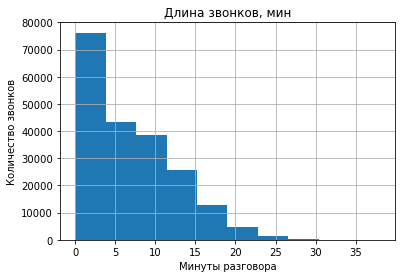

In [6]:
# изучим количество звонков на аномалии
df_calls['duration'].hist()
plt.title('Длина звонков, мин')
plt.xlabel('Минуты разговора')
plt.ylabel('Количество звонков')
None

Есть недозвоны, потому видим пик на нуле, разговоров больше 25 минут практически нет.

In [7]:
df_calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


По условиям, мы помним, что 0 - это несостоявшийся звонок. Посмотрим сколько таких звонков:

In [8]:
len(df_calls.query('duration == 0'))/len(df_calls)*100

19.551644316336553

23% звонков - недозвоны, могу предположить, что это может быть реальным сценарием в жизни.

In [9]:
# таблица internet (информация об интернет-сессиях):
try:
    df_internet = pd.read_csv('/datasets/internet.csv', index_col=0)
except:
    df_internet = pd.read_csv('internet.csv', index_col=0)
df_internet.head(15)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.70,2018-07-11,1000
8,1000_8,505.40,2018-10-08,1000
9,1000_9,345.54,2018-09-03,1000


In [10]:
# сколько уникальныз юзеров пользовалось инетом
len(df_internet['user_id'].unique())

497

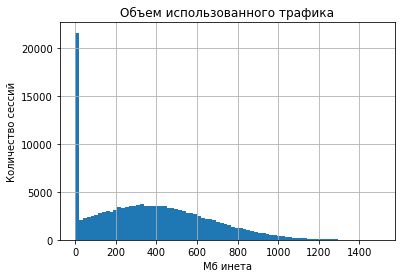

In [11]:
# изучим объем израсходованного трафика на аномалии
df_internet['mb_used'].hist(bins=80, range=(0,1500))
plt.title('Объем использованного трафика')
plt.xlabel('Мб инета')
plt.ylabel('Количество сессий')
None

Пик приходится где-то на 500 Мб инета, практически нет сессий больше чем на 1200 мб. Кажется, что это мало, но возможно в выборке есть взрослые люди, кто не пользуется интернетом вообще или пользуется очень мало.

In [12]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


In [13]:
df_internet.describe()

,mb_used,user_id
count,149396.000000,149396.000000
mean,370.192426,1252.099842
std,278.300951,144.050823
min,0.000000,1000.000000
25%,138.187500,1130.000000
50%,348.015000,1251.000000
75%,559.552500,1380.000000
max,1724.830000,1499.000000


In [14]:
# таблица users (информация о пользователях):
try:
    df_users = pd.read_csv('/datasets/users.csv')
except:
    df_users = pd.read_csv('users.csv')
df_users.head(15)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


In [15]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [16]:
len(df_users['user_id'].unique())

500

In [17]:
# таблица messages (информация о сообщениях):
try:
    df_message = pd.read_csv('/datasets/messages.csv')
except:
    df_message = pd.read_csv('messages.csv')
df_message.head(15)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [18]:
df_message.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [19]:
# сколько уникальных юзеров пользовалось смс
len(df_message['user_id'].unique())

426

In [20]:
df_message.describe()

,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


In [21]:
# таблица tariffs (информация о тарифах)
try:
    df_tariffs = pd.read_csv('/datasets/tariffs.csv')
except:
    df_tariffs = pd.read_csv('tariffs.csv')
df_tariffs.head(15)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [22]:
df_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


#### Вывод:

Предварительно в таблицах нет аномальных данных

Видим, что в следующем шаге помимо прочего нужно:

duration - привести к целочисленному типу

call_date- привести в формат даты

session_date- привести в формат даты

mb_used - привести к целочисленному типу, помнить, что округление должно бытьв  большую сторону. Перевести мб в гб. 

reg_date - к формату даты 



In [23]:
# check
set(df_users.user_id) - set(df_calls.user_id)

{1091, 1106, 1128, 1231, 1328, 1371, 1473, 1489}

# [Шаг 2. Предобработка данных](#section_id5)


## [Приведем данные к нужным типам](#section_id6)

In [24]:
df_internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [25]:
# приведем к целочисленному типу количество звонков
df_calls['duration'] = df_calls['duration'].apply(np.ceil).astype('int')
df_calls['duration'].value_counts().head()

0    39613
7    11510
6    11457
5    11411
8    11272
Name: duration, dtype: int64

In [26]:
# к формату даты
df_calls['call_date'] = pd.to_datetime(
    df_calls['call_date'], format='%Y-%m-%d')
# проверим, что все ок
df_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000


In [27]:
df_message['message_date'] = pd.to_datetime(
    df_message['message_date'], format='%Y-%m-%d')
df_message['message_date'].head()

0   2018-06-27
1   2018-10-08
2   2018-08-04
3   2018-06-16
4   2018-12-05
Name: message_date, dtype: datetime64[ns]

In [28]:
df_internet['session_date'] = pd.to_datetime(
    df_internet['session_date'], format='%Y-%m-%d')
df_internet['session_date'].head()

0   2018-11-25
1   2018-09-07
2   2018-06-25
3   2018-08-22
4   2018-09-24
Name: session_date, dtype: datetime64[ns]

In [29]:
df_users['reg_date'] = pd.to_datetime(
    df_internet['session_date'], format='%Y-%m-%d')
df_users['reg_date'].head()

0   2018-11-25
1   2018-09-07
2   2018-06-25
3   2018-08-22
4   2018-09-24
Name: reg_date, dtype: datetime64[ns]

## [Проверим данные на явные дубликаты:](#section_id7)

In [30]:
df_calls.duplicated().sum()

0

In [31]:
df_internet.duplicated().sum()

0

In [32]:
df_users.duplicated().sum()

0

In [33]:
df_message.duplicated().sum()

0

In [34]:
df_users.duplicated().sum()

0

## Проверим данные на неявные дубликаты:

In [35]:
df_users_unique = df_users['city'].unique()
df_users_unique.sort()
df_users_unique


array(['Архангельск', 'Астрахань', 'Балашиха', 'Барнаул', 'Белгород',
       'Брянск', 'Владивосток', 'Владикавказ', 'Владимир', 'Волгоград',
       'Волжский', 'Вологда', 'Воронеж', 'Грозный', 'Екатеринбург',
       'Иваново', 'Ижевск', 'Иркутск', 'Казань', 'Калининград', 'Калуга',
       'Кемерово', 'Киров', 'Кострома', 'Краснодар', 'Красноярск',
       'Курган', 'Курск', 'Липецк', 'Магнитогорск', 'Махачкала', 'Москва',
       'Мурманск', 'Набережные Челны', 'Нижневартовск', 'Нижний Новгород',
       'Нижний Тагил', 'Новокузнецк', 'Новороссийск', 'Новосибирск',
       'Омск', 'Оренбург', 'Орёл', 'Пенза', 'Пермь', 'Петрозаводск',
       'Подольск', 'Ростов-на-Дону', 'Рязань', 'Самара',
       'Санкт-Петербург', 'Саранск', 'Саратов', 'Севастополь', 'Смоленск',
       'Сочи', 'Ставрополь', 'Стерлитамак', 'Сургут', 'Тамбов', 'Тверь',
       'Тольятти', 'Томск', 'Тула', 'Тюмень', 'Улан-Удэ', 'Ульяновск',
       'Уфа', 'Хабаровск', 'Химки', 'Чебоксары', 'Челябинск', 'Череповец',
       'Чи

Убудились, что в данных нет дубликатов.

## Добавим столбцы с месяцами в нужные нам таблицы:

In [36]:
# добавим столбец с месяцами в таблицу со звонками
df_calls['month'] = pd.DatetimeIndex(df_calls['call_date']).month
df_calls['month'].value_counts()

12    33987
11    29501
10    27146
9     24061
8     21488
7     18298
6     14716
5     12647
4      9272
3      6687
2      3328
1      1476
Name: month, dtype: int64

In [37]:
# добавим столбец с месяцами в таблицу с сообщениями
df_message['month'] = pd.DatetimeIndex(df_message['message_date']).month
df_message['month'].value_counts()

12    20555
11    18244
10    17114
9     14759
8     13088
7     11320
6      8983
5      7298
4      5179
3      3648
2      1924
1       924
Name: month, dtype: int64

In [38]:
# добавим столбец с месяцами в таблицу с трафиком
df_internet['month'] = pd.DatetimeIndex(df_internet['session_date']).month
df_internet['month'].value_counts()

12    24799
11    21817
10    20009
9     17512
8     16092
7     13548
6     11057
5      9408
4      6511
3      4885
2      2641
1      1117
Name: month, dtype: int64

In [39]:
#удалим столбцы, которые нам не понадобятся
df_users = df_users.drop(['first_name','last_name','churn_date', 'reg_date'], axis=1)
df_users.head()

,user_id,age,city,tariff
0,1000,52,Краснодар,ultra
1,1001,41,Москва,smart
2,1002,59,Стерлитамак,smart
3,1003,23,Москва,ultra
4,1004,68,Новокузнецк,ultra


## Посчитаем количество сделанных звонков и израсходованных минут по месяцам:

In [40]:
calls_total = df_calls.groupby(['user_id', 'month'],
as_index = False).agg({'duration':'sum', 
'id':'count'}).rename(columns={'duration':'calls_sum','id':'calls_count'})
calls_total.head()

,user_id,month,calls_sum,calls_count
0,1000,5,159,22
1,1000,6,172,43
2,1000,7,340,47
3,1000,8,408,52
4,1000,9,466,58


In [41]:
calls_total.describe()

,user_id,month,calls_sum,calls_count
count,3174.000000,3174.000000,3174.000000,3174.000000
mean,1251.555766,8.311594,456.931632,63.833333
std,144.470630,2.910625,238.031270,32.678036
min,1000.000000,1.000000,0.000000,1.000000
25%,1126.000000,6.000000,290.000000,41.000000
50%,1254.000000,9.000000,447.000000,63.000000
75%,1378.000000,11.000000,592.000000,83.000000
max,1499.000000,12.000000,1673.000000,244.000000


В среднем количество минут в разговоре не превышает 500 минут, данные выглядят адекватно, несмотря на максимум.

## Посчитаем количество сообщений по месяцам:

In [42]:
message_total = df_message.groupby(['user_id', 'month'],
as_index = False).agg({'id':'count'}).rename(columns={'id':'message_count'})
message_total.head()

,user_id,month,message_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


In [43]:
message_total.describe()

,user_id,month,message_count
count,2717.000000,2717.000000,2717.000000
mean,1255.635259,8.345234,45.283769
std,146.227484,2.892920,35.051363
min,1000.000000,1.000000,1.000000
25%,1126.000000,6.000000,19.000000
50%,1266.000000,9.000000,38.000000
75%,1384.000000,11.000000,63.000000
max,1499.000000,12.000000,224.000000


В среднем пользователи отправляют 45 сообщений в мес, данные выглядят правдоподобно.

## Посчитаем объем трафика по месяцам:

In [44]:
# суммируем объем интернета за месяц потребления каждым юзером
internet_total = df_internet.groupby(['user_id', 'month'],
as_index = False).agg({'mb_used':'sum'})
internet_total.head()

,user_id,month,mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91


Переведем Мб в Гб и округлим в большую сторону(по условиям тарифов):

In [45]:
# переведем МБ в ГБ
internet_total['mb_used'] = internet_total['mb_used']/1024
internet_total['mb_used'].head()

0     2.200674
1    22.689229
2    13.675430
3    13.726494
4    14.227451
Name: mb_used, dtype: float64

In [46]:
# пененазовем столбец
internet_total.rename(columns={'mb_used': 'gb'}, inplace=True)
internet_total.head()

,user_id,month,gb
0,1000,5,2.200674
1,1000,6,22.689229
2,1000,7,13.675430
3,1000,8,13.726494
4,1000,9,14.227451


In [47]:
# округлим в большую сторону
internet_total['gb'] = internet_total['gb'].apply(np.ceil).astype('int')
internet_total.head()

,user_id,month,gb
0,1000,5,3
1,1000,6,23
2,1000,7,14
3,1000,8,14
4,1000,9,15


In [48]:
internet_total.describe()

,user_id,month,gb
count,3203.000000,3203.000000,3203.000000
mean,1251.393069,8.320949,17.358414
std,144.824407,2.903834,7.343379
min,1000.000000,1.000000,0.000000
25%,1124.000000,6.000000,13.000000
50%,1251.000000,9.000000,17.000000
75%,1379.000000,11.000000,21.000000
max,1499.000000,12.000000,49.000000


Среднее- 17 Гб и максимум 49 Гб в мес, есть 0 ГБ, вероятно эти пользователи не пользуются инетом.

## Посчитаем месячную выручку с каждого пользователя:

In [49]:
# объединим таблицы:
df_revenue = calls_total.merge(message_total, 
on=['user_id','month'], how='outer').merge(internet_total, 
on=['user_id','month'], how = 'outer')
df_revenue.head()

,user_id,month,calls_sum,calls_count,message_count,gb
0,1000,5,159.0,22.0,22.0,3.0
1,1000,6,172.0,43.0,60.0,23.0
2,1000,7,340.0,47.0,75.0,14.0
3,1000,8,408.0,52.0,81.0,14.0
4,1000,9,466.0,58.0,57.0,15.0


In [50]:
# check
df_revenue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        3214 non-null   int64  
 1   month          3214 non-null   int64  
 2   calls_sum      3174 non-null   float64
 3   calls_count    3174 non-null   float64
 4   message_count  2717 non-null   float64
 5   gb             3203 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 175.8 KB


Добавим информацию о тарифе:

In [51]:
# переименуем название тарифа в таблице с тарифами, чтобы смогли объединить:
df_tariffs = df_tariffs.rename(columns={'tariff_name': 'tariff'})
df_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [52]:
#соединим таблицы
total_tariff = pd.merge(df_users, df_tariffs, 
         left_on='tariff', right_on='tariff', how='outer')
total_tariff.head()

,user_id,age,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,Краснодар,ultra,1000,30720,3000,1950,150,1,1
1,1003,23,Москва,ultra,1000,30720,3000,1950,150,1,1
2,1004,68,Новокузнецк,ultra,1000,30720,3000,1950,150,1,1
3,1013,36,Иваново,ultra,1000,30720,3000,1950,150,1,1
4,1016,58,Омск,ultra,1000,30720,3000,1950,150,1,1


In [53]:
df_revenue = pd.merge(df_revenue, total_tariff, 
         left_on='user_id', right_on='user_id', how='outer')
df_revenue.head()

,user_id,month,calls_sum,calls_count,message_count,gb,age,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5.0,159.0,22.0,22.0,3.0,52,Краснодар,ultra,1000,30720,3000,1950,150,1,1
1,1000,6.0,172.0,43.0,60.0,23.0,52,Краснодар,ultra,1000,30720,3000,1950,150,1,1
2,1000,7.0,340.0,47.0,75.0,14.0,52,Краснодар,ultra,1000,30720,3000,1950,150,1,1
3,1000,8.0,408.0,52.0,81.0,14.0,52,Краснодар,ultra,1000,30720,3000,1950,150,1,1
4,1000,9.0,466.0,58.0,57.0,15.0,52,Краснодар,ultra,1000,30720,3000,1950,150,1,1


In [54]:
df_revenue.isna().sum()

user_id                    0
month                      2
calls_sum                 42
calls_count               42
message_count            499
gb                        13
age                        0
city                       0
tariff                     0
messages_included          0
mb_per_month_included      0
minutes_included           0
rub_monthly_fee            0
rub_per_gb                 0
rub_per_message            0
rub_per_minute             0
dtype: int64

In [55]:
df_revenue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3216 non-null   int64  
 1   month                  3214 non-null   float64
 2   calls_sum              3174 non-null   float64
 3   calls_count            3174 non-null   float64
 4   message_count          2717 non-null   float64
 5   gb                     3203 non-null   float64
 6   age                    3216 non-null   int64  
 7   city                   3216 non-null   object 
 8   tariff                 3216 non-null   object 
 9   messages_included      3216 non-null   int64  
 10  mb_per_month_included  3216 non-null   int64  
 11  minutes_included       3216 non-null   int64  
 12  rub_monthly_fee        3216 non-null   int64  
 13  rub_per_gb             3216 non-null   int64  
 14  rub_per_message        3216 non-null   int64  
 15  rub_

Вероятно, пропуски в таблице -говорят о том, что в этот  период не было звонков

In [56]:
# есть 2 пропуска в month - можно удалить без влияния на результат
df_revenue = df_revenue.dropna(subset = ['month']).reset_index(drop=True)
df_revenue.isna().sum()

user_id                    0
month                      0
calls_sum                 40
calls_count               40
message_count            497
gb                        11
age                        0
city                       0
tariff                     0
messages_included          0
mb_per_month_included      0
minutes_included           0
rub_monthly_fee            0
rub_per_gb                 0
rub_per_message            0
rub_per_minute             0
dtype: int64

In [57]:
# в остальных данных пропуски обозначают 0
df_revenue['calls_sum'] = df_revenue['calls_sum'].fillna(value = 0).astype(int)
df_revenue['calls_count'] = df_revenue['calls_count'].fillna(value = 0).astype(int)
df_revenue['message_count'] = df_revenue['message_count'].fillna(value = 0).astype(int)
df_revenue['gb'] = df_revenue['gb'].fillna(value = 0).astype(int)
df_revenue.isna().sum()

user_id                  0
month                    0
calls_sum                0
calls_count              0
message_count            0
gb                       0
age                      0
city                     0
tariff                   0
messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
dtype: int64

Переведем МБ в ГБ  в колонке mb_per_month_included.

In [58]:
df_revenue['mb_per_month_included'] = df_revenue['mb_per_month_included']/1024
# пененазовем столбец
df_revenue.rename(columns={'mb_per_month_included': 'gb_per_month_included'}, inplace=True)
# приведем к целочисленному типу
df_revenue['gb_per_month_included'] = df_revenue['gb_per_month_included'].astype('int')
df_revenue['gb_per_month_included'].min()

15

In [59]:
# напишем функцию, которая поможет вычесть бесплатный лимит из суммарного количества звонков,
# сообщений и интернет- трафика; остаток умножим на значение из тарифного плана

def revenue (row):
    
    if row ['message_count']>row['messages_included']: 
        message = (row['message_count'] - row['messages_included']) * row['rub_per_message']
    else:
        message = 0
    if row['calls_sum']>row['minutes_included']:
        calls = (row['calls_sum'] - row['minutes_included']) * row['rub_per_minute']
    else:
        calls=0
    if row['gb']>row['gb_per_month_included']:
        gbs = (row['gb'] - row['gb_per_month_included']) * row['rub_per_gb']
    else:
            gbs=0
            
# сложим оплату за гб, минуты и сообщения сверх тарифов:
    total = 0
    for i in [message, calls, gbs]:
        if i > 0:
            total += i
    return total           
      
df_revenue['total revenue'] = df_revenue.apply(revenue,axis=1)

# прибавим абонентскую плату, соответствующую тарифному плану:
df_revenue['total revenue'] = df_revenue['total revenue']+df_revenue['rub_monthly_fee']


# убедимся, что все ок
df_revenue.sort_values(by='total revenue', ascending = False).head()

,user_id,month,calls_sum,calls_count,message_count,gb,age,city,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,total revenue
3108,1486,12.0,1007,133,83,38,35,Нижний Новгород,smart,50,15,500,550,200,3,3,6770
260,1042,12.0,728,121,75,37,42,Хабаровск,smart,50,15,500,550,200,3,3,5709
3107,1486,11.0,764,108,96,36,35,Нижний Новгород,smart,50,15,500,550,200,3,3,5680
1622,1261,12.0,1074,141,22,32,46,Казань,smart,50,15,500,550,200,3,3,5672
1793,1286,12.0,739,95,68,35,19,Москва,smart,50,15,500,550,200,3,3,5321


In [60]:
df_revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3214 non-null   int64  
 1   month                  3214 non-null   float64
 2   calls_sum              3214 non-null   int32  
 3   calls_count            3214 non-null   int32  
 4   message_count          3214 non-null   int32  
 5   gb                     3214 non-null   int32  
 6   age                    3214 non-null   int64  
 7   city                   3214 non-null   object 
 8   tariff                 3214 non-null   object 
 9   messages_included      3214 non-null   int64  
 10  gb_per_month_included  3214 non-null   int32  
 11  minutes_included       3214 non-null   int64  
 12  rub_monthly_fee        3214 non-null   int64  
 13  rub_per_gb             3214 non-null   int64  
 14  rub_per_message        3214 non-null   int64  
 15  rub_

In [61]:
df_revenue['total revenue'].describe()

count    3214.000000
mean     1529.076229
std       798.251091
min       550.000000
25%       750.000000
50%      1653.500000
75%      1950.000000
max      6770.000000
Name: total revenue, dtype: float64

В среднем пользователи платят 1077 рубллей  в мес, максимум - 3397, вероятно на тарифе Ультра.

#### Вывод:

Мы привели данные к нужным типам.

Проверили их на явные и неявные дубликаты.

Добавили столбцы с месяцами в нужные таблицы.

Посчитали для каждого пользователя:

* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя (вычли бесплатный лимит из суммарного количества звонков, сообщений и интернет- трафика; остаток умножили на значение из тарифного плана; прибавили абонентскую плату, соответствующую тарифному плану).
И можем переходить к следующему шагу.

In [62]:
# check
df_revenue['total revenue'].sum()

4914451

In [63]:
# check
df_revenue[df_revenue['calls_sum'] > 500][['user_id', 'month', 'calls_sum', 'calls_count', 'message_count', 'gb',
        'tariff',  'total revenue']].tail()

,user_id,month,calls_sum,calls_count,message_count,gb,tariff,total revenue
3160,1496,8.0,527,88,41,23,smart,2231
3163,1496,11.0,662,80,46,25,smart,3036
3164,1496,12.0,518,80,51,21,smart,1807
3167,1497,12.0,545,71,17,20,smart,1685
3174,1499,11.0,612,74,59,18,smart,1513


# [Шаг 3. Анализ данных](#section_id6)


Посмотрим-какое распределение клиентов по тарифам.

In [64]:
# клиенты тарифа смарт
df_revenue_smart = df_revenue.query('tariff=="smart"')
len(df_revenue_smart['user_id'].unique())

350

In [65]:
# клиенты тарифа ультра
df_revenue_ultra = df_revenue.query('tariff=="ultra"')
len(df_revenue_ultra['user_id'].unique())

148

Тариф смарт значительно популярнее среди пользователей. Это можно объяснить тем, что предоставляемые объемы трафиков подходят для большего количества людей, плюс он дешевле.

#### 3.1. Посчитаем -сколько минут разговора, сообщений и какой объем трафика требуется пользователям тарифа smart в месяц.

In [66]:

df_revenue_smart_mean = df_revenue_smart.pivot_table(index=['month'], values= ['calls_sum', 'message_count', 'gb'], aggfunc='mean').round(2)
df_revenue_smart_mean 

,calls_sum,gb,message_count
month,,,
1.0,203.85,8.74,18.24
2.0,298.69,11.84,24.09
3.0,390.05,15.23,31.86
4.0,367.13,13.62,30.74
5.0,387.36,15.91,33.77
6.0,395.64,15.95,33.40
7.0,408.35,15.88,33.75
8.0,421.47,16.74,33.64
9.0,428.61,16.39,33.64


In [67]:
df_revenue_smart['calls_sum'].mean()

417.9349484073576

In [68]:
df_revenue_smart['message_count'].mean()

33.384028712427096

In [69]:
df_revenue_smart['gb'].mean()

16.328847016599372

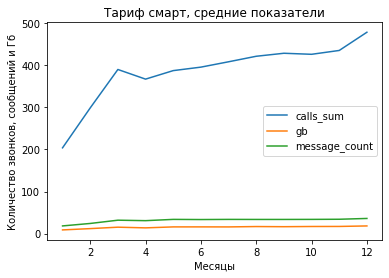

In [70]:
df_revenue_smart_mean.plot(y = ['calls_sum', 'gb', 'message_count'])
plt.title('Тариф смарт, средние показатели')
plt.xlabel('Месяцы')
plt.ylabel('Количество звонков, сообщений и Гб')
None

Видим, что в среднем, пользователи разговаривают 526 минут в месяц.

В среднем - количество сообщений 49.

В среднем Гб инета - 19.


Посмотрим, сколько было превышения лимитов

In [71]:
# превышение лимитов по звонкам
len(df_revenue_smart.query('calls_sum>500')) 

754

In [72]:
len(df_revenue_smart.query('calls_sum>500'))/len(df_revenue_smart)*100

33.82682817406909

в 52% месяцев был превышен лимит по длительности звонков

In [73]:
# превышение лимитов по сообщениям
len(df_revenue_smart.query('message_count>50')) 
len(df_revenue_smart.query('message_count>50'))/len(df_revenue_smart)*100

25.3028263795424

В 40% был превышен лимит по сообщениям

In [74]:
# превышение лимитов по Гб инета
len(df_revenue_smart.query('gb>15')) 
len(df_revenue_smart.query('gb>15'))/len(df_revenue_smart)*100

58.50157021085689

В 64% превышен лимит по Гб. 

## Посчитаем -сколько требуется пользователям тарифа ultra в месяц.

Расчет ср. длительности пользования тарифом, ultra vs smart по различным группам (объединение по месяцу, городу ...)

Скорость оттока пользователей и связана она с тарифом

Ускоряется ли отток клиентов

Скорость подключения клиентов по городам (в каких городах быстрее)

Кто чем больше пользуется — распределение по возрастным группам (молодежь интернетом, более старшее поколение - звонками)

In [75]:
df_revenue_ultra = df_revenue.query('tariff=="ultra"')
df_revenue_ultra_mean = df_revenue_smart.pivot_table(index=['month'], values= ['calls_sum', 'message_count', 'gb'], aggfunc='mean').round(2)
df_revenue_ultra_mean 

,calls_sum,gb,message_count
month,,,
1.0,203.85,8.74,18.24
2.0,298.69,11.84,24.09
3.0,390.05,15.23,31.86
4.0,367.13,13.62,30.74
5.0,387.36,15.91,33.77
6.0,395.64,15.95,33.40
7.0,408.35,15.88,33.75
8.0,421.47,16.74,33.64
9.0,428.61,16.39,33.64


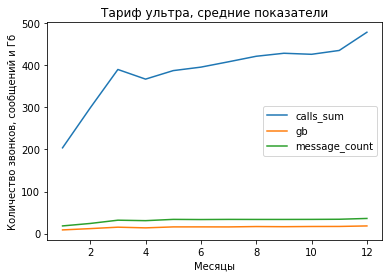

In [76]:
df_revenue_ultra_mean.plot(y = ['calls_sum', 'gb', 'message_count'])
plt.title('Тариф ультра, средние показатели')
plt.xlabel('Месяцы')
plt.ylabel('Количество звонков, сообщений и Гб')
None

In [77]:
df_revenue_ultra['calls_sum'].mean()

526.6233502538071

In [78]:
df_revenue_ultra['gb'].mean()

19.494416243654822

In [79]:
df_revenue_ultra['message_count'].mean()

49.36345177664975

Видим, что как и в тарифе smart в среднем, пользователи тратят 526 минут.

В среднем - количество сообщений 49

В среднем Гб инета - 19. 

Посмотрим, сколько пользователей превышает лимиты.

In [80]:
# превышение лимитов по звонкам
len(df_revenue_ultra.query('calls_sum>3000')) #0
len(df_revenue_ultra.query('calls_sum>3000'))/len(df_revenue_ultra)*100

0.0

In [81]:
# превышение лимитов по сообщениям
len(df_revenue_ultra.query('message_count>1000')) #0
len(df_revenue_ultra.query('message_count>1000'))/len(df_revenue_ultra)*100

0.0

In [82]:
# превышение лимитов по Гб инета
len(df_revenue_ultra.query('gb>30')) #117
len(df_revenue_ultra.query('gb>30'))/len(df_revenue_ultra)*100

13.604060913705585

В тарифе Ultra пользователи превышают лимит только в Гб - в 13 %. Остальные находятся в рамках своего тарифа.

#### Посчитаем среднее, дисперсию, стандартное отклонение и построим гистограмму.

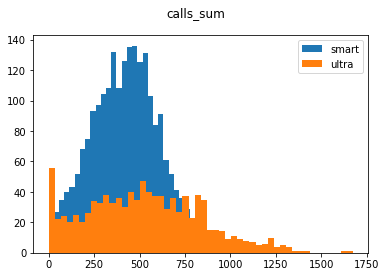

              mean            var         std
         calls_sum      calls_sum   calls_sum
tariff                                       
smart   417.934948   36219.315784  190.313730
ultra   526.623350  100873.633397  317.606098


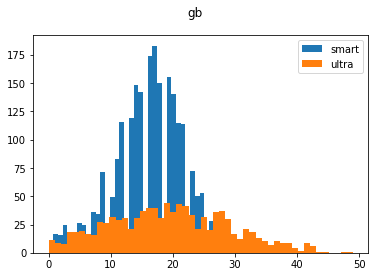

             mean        var       std
               gb         gb        gb
tariff                                
smart   16.328847  33.028705  5.747061
ultra   19.494416  97.091686  9.853511


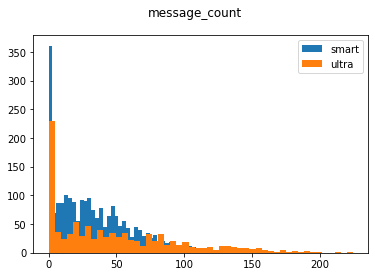

                mean           var           std
       message_count message_count message_count
tariff                                          
smart      33.384029    796.812958     28.227876
ultra      49.363452   2285.266143     47.804457


In [83]:
for column in ['calls_sum', 'gb', 'message_count']:  
    plt.hist(df_revenue_smart[column],bins=50, label='smart')
    plt.hist(df_revenue_ultra[column],bins=50, label='ultra')
    plt.legend(loc='upper right')
    plt.suptitle(column)
    plt.show()
    print(df_revenue.pivot_table(index = 'tariff',values=column,aggfunc = ['mean','var','std']))

Звонки - есть небольшой пик на 0, когда были недозвоны.
Данные распределены нормально, в датасете с Гб данные так же распределены нормально.
У сообщений есть выброс на 0- когда сообщениями не пользовались, при этом датасет скошен вправо, незначительное количество сообщений больше 150.

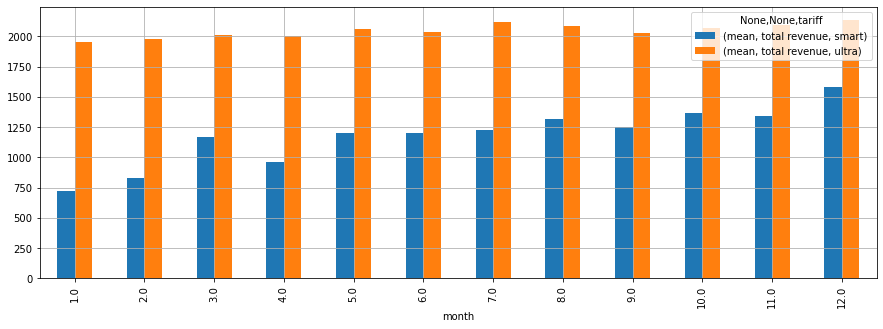

In [84]:
df_revenue.pivot_table(index='month', columns = 'tariff', values=['total revenue'], aggfunc = ['mean']).plot(kind="bar", figsize=(15, 5), grid=True)
None

Тариф ультра ежемесячно в среднем приносит больше денег.


#### Вывод:

Пользователи тарифа Смарт в среднем ежемесячно совершают 417 звонков, отправляют 33 сообщения и используют 16 Гб.
Пользователи тарифа Ультра в среднем ежемесячно совершают 526 звонков, отправляют 49 сообщений и используют 19 Гб.
У датасетов по звонкам и гб-нормальное распределение. Датасет по сообщениям скошен вправо.

Тариф smart является более популярным, чем тариф ультра.
При этом в 52% данных по месяцам был превышен лимит по длительности звонков, в 40% был превышен лимит по сообщениям, в 64% превышен лимит по Гб.

В тарифе ultra превышает лимит только только в Гб - 13 % .

# [Шаг 4. Проверка гипотез](#section_id7)

#### 4.1. Сформируем и проверим  гипотезу: "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются"

**Н0**:средняя выручка пользователей тарифов «Ультра» и «Смарт» равны (нулевая гипотеза всегда должна быть равна чему-то конкретному).

**H1**: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

In [85]:
df_revenue_ultra['total revenue'].mean()

2070.1522842639592

In [86]:
df_revenue_smart['total revenue'].mean()

1289.9735307312696

In [87]:
revenue_ultra = df_revenue_ultra['total revenue']
revenue_smart = df_revenue_smart['total revenue']
alpha = .05
results = st.ttest_ind(revenue_ultra, revenue_smart, equal_var = False)
print('p-значение:', results.pvalue) 

if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.2606313931076085e-250
Отвергаем нулевую гипотезу


По результатам мы видим, что можем отвергнуть нулевую гипотезу. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются. Тогда интересно ответить на вопрос- какой тариф приносит больше денег:

In [88]:
df_revenue.pivot_table(index='month', columns = 'tariff', values=['total revenue'], aggfunc = 'mean')

total revenue             
tariff         smart        ultra
month                            
1.0       721.323529  1950.000000
2.0       827.603448  1975.000000
3.0      1164.623377  2014.864865
4.0       963.089286  2001.818182
5.0      1197.510638  2059.701493
6.0      1204.018293  2039.285714
7.0      1223.950249  2118.131868
8.0      1320.595745  2083.177570
9.0      1249.946154  2024.347826
10.0     1364.853741  2065.853659
11.0     1343.047468  2092.164179
12.0     1578.531157  2138.848921

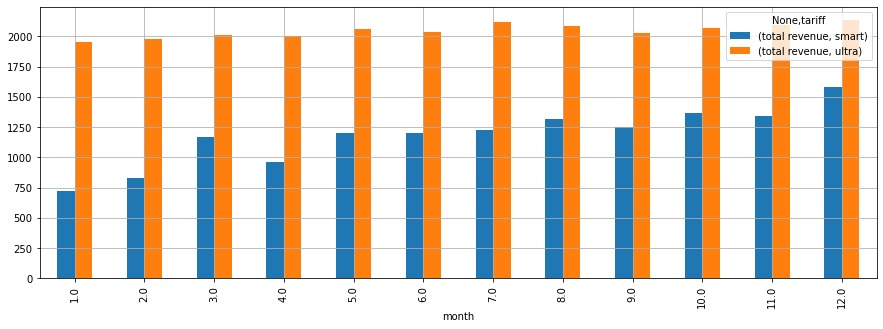

In [89]:
df_revenue.pivot_table(index='month', columns = 'tariff', values=['total revenue'], aggfunc = 'mean').plot(kind="bar", figsize=(15, 5), grid=True)
None

In [90]:
df_revenue.pivot_table(index='tariff', values='total revenue', aggfunc = 'mean')

,total revenue
tariff,
smart,1289.973531
ultra,2070.152284


Мы видим, что тариф Ультра ежемесячно стабильно приносит больше денег, чем смарт, несомтря на то, что у Смарта пользователи выходят за границы тарифы и платят дополнительно.

**4.2. Сформируем и проверим гипотезу: "Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.**

**Н0**:средняя выручка пользователей Москвы и других регионов равны (нулевая гипотеза всегда должна быть равна чему-то конкретному).

**H1**: средняя выручка пользователей пользователей Москвы и других регионов различается.

In [91]:
# сделаем выборки Мск и других регионов и посмотрим их размер
revenue_msk = df_revenue.query('city=="Москва"')
revenue_msk = revenue_msk['total revenue']
len(revenue_msk)

611

In [92]:
revenue_outher  = df_revenue.query('city!="Москва"')
revenue_outher = revenue_outher['total revenue']
len(revenue_outher)

2603

In [93]:
alpha = .05
results = st.ttest_ind(revenue_msk, revenue_outher, equal_var = False)
print('p-значение:', results.pvalue) 

if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


Значение p-value показывает: вероятность случайно получить такое или большее различие равно 52%-это очень много. Мы не можем сделать вывод о различии. Мы использовали дополнительный параметр equal_var = False, потому что у нас не одинаковые по размеру выборки. Мы не можем утверждать, что выручка в Мск и других регионах действительно разные.

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> классическая формулировка расшифровки р-значения, молодец

In [94]:
revenue_msk.mean()

1546.7135842880523

In [95]:
revenue_outher.mean()

1524.9362274298885

In [96]:
df_revenue['region'] = np.where(df_revenue['city'] == 'Москва', 'Москва', 'Другие регионы')

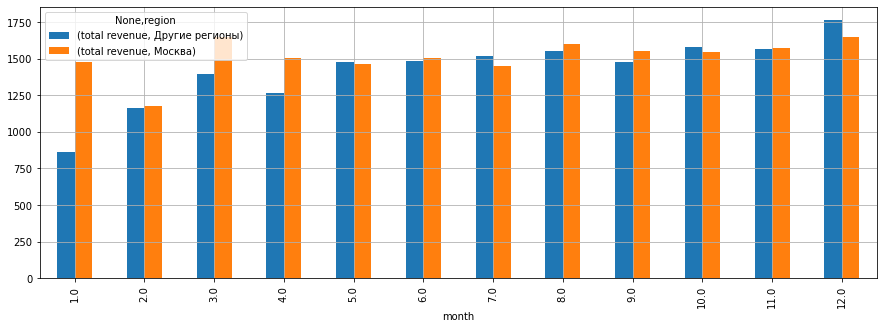

In [97]:
df_revenue.pivot_table(index='month', columns = 'region', values=['total revenue'], aggfunc = 'mean').plot(kind="bar", figsize=(15, 5), grid=True)
None

# [Шаг 5. Вывод](#section_id8)


Пользователи тарифа Смарт в среднем ежемесячно совершают 417 звонков, отправляют 33 сообщения и используют 16 Гб.

Пользователи тарифа Ультра в среднем ежемесячно совершают 526 звонков, отправляют 49 сообщений и используют 19 Гб.
У датасетов по звонкам и гб-нормальное распределение. Датасет по сообщениям скошен вправо.

Тариф smart является более популярным, чем тариф ультра.
При этом в 52% данных по месяцам был превышен лимит по длительности звонков, в 40% был превышен лимит по сообщениям, в 64% превышен лимит по Гб.

В тарифе ultra превышает лимит только только в Гб - 13 % .

**Результаты проверки гипотез**

Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются. Пользователи тарифа "Ультра" ежемесячно стабильно приносят больше денег, чем пользователи тарифа "Cмарт", несмотря на то, что у Смарта пользователи выходят за границы тарифы и платят дополнительно. 

Мы не можем сделать вывод о том, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Тариф Ультра точно более выгоден для компании - учитывая, что половина его пользователей все равно остается в пределах тех же значений по использованию минут, сообщений и Гб, что и пользователи тарифа Смарт, при этом средняя выручка от пользователей стабильно выше.


